# Strategy Comparison and Result Presentation

This notebook presents a comprehensive analysis of trading strategy performance, including:

- Signal overlay with buy markers on price charts
- Holdings, cash balance, and total portfolio value over time  
- Cumulative PnL comparison across strategies
- Reflection on signal behavior, execution constraints, and performance


In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from PriceLoader import PriceLoader
from Simulator import Simulator
from MovingAverageStrategy import MovingAverageStrategy
from MACDStrategy import MACDStrategy
from VolatilityBreakoutStrategy import VolatilityBreakoutStrategy
from RSIStrategy import RSIStrategy
from BenchmarkStrategy import BenchmarkStrategy

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load price data and initialize simulator
print("Loading price data...")
pl = PriceLoader()
tickers = pl.available_ticker
print(f"Found {len(tickers)} tickers")

# Load price data for all tickers
stocks = {t: pl.load_price_data(t) for t in tickers}
prices = pd.concat(stocks, axis=1)
prices.columns = prices.columns.droplevel(1)

print(f"Price data shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")

# Initialize simulator and run all strategies
print("\nInitializing simulator and running strategies...")
s = Simulator()
s.run_strats()

# Get strategy names and results
strategy_names = ['MovingAverageStrategy', 'VolatilityBreakoutStrategy', 'RSIStrategy', 'MACDStrategy', 'BenchmarkStrategy']
strategies = s.strat

print("All strategies completed successfully!")

# Debug: Check dimensions to prevent plotting errors
print("\nDimension Check:")
print(f"Price data length: {len(prices)}")
for i, (name, strategy) in enumerate(zip(strategy_names, strategies)):
    portfolio_length = len(strategy.portfolio_value)
    print(f"{name}: Portfolio values length = {portfolio_length}")
    if portfolio_length != len(prices):
        print(f"Dimension mismatch: {portfolio_length} vs {len(prices)}")


Loading price data...
Found 463 tickers
Successfully loaded data for CBRE. Shape: (2516, 1)
Successfully loaded data for MCO. Shape: (2516, 1)
Successfully loaded data for EMN. Shape: (2516, 1)
Successfully loaded data for TGT. Shape: (2516, 1)
Successfully loaded data for CI. Shape: (2516, 1)
Successfully loaded data for HAL. Shape: (2516, 1)
Successfully loaded data for DGX. Shape: (2516, 1)
Successfully loaded data for GPN. Shape: (2516, 1)
Successfully loaded data for IQV. Shape: (2516, 1)
Successfully loaded data for BSX. Shape: (2516, 1)
Successfully loaded data for RL. Shape: (2516, 1)
Successfully loaded data for AMZN. Shape: (2516, 1)
Successfully loaded data for WSM. Shape: (2516, 1)
Successfully loaded data for KEYS. Shape: (2516, 1)
Successfully loaded data for DHI. Shape: (2516, 1)
Successfully loaded data for PFG. Shape: (2516, 1)
Successfully loaded data for CMS. Shape: (2516, 1)
Successfully loaded data for KO. Shape: (2516, 1)
Successfully loaded data for CTRA. Shape: 

## Signal Overlay Analysis

Let's examine how each strategy generates signals and overlays them on price charts for a sample stock.


Analyzing signals for: AAPL


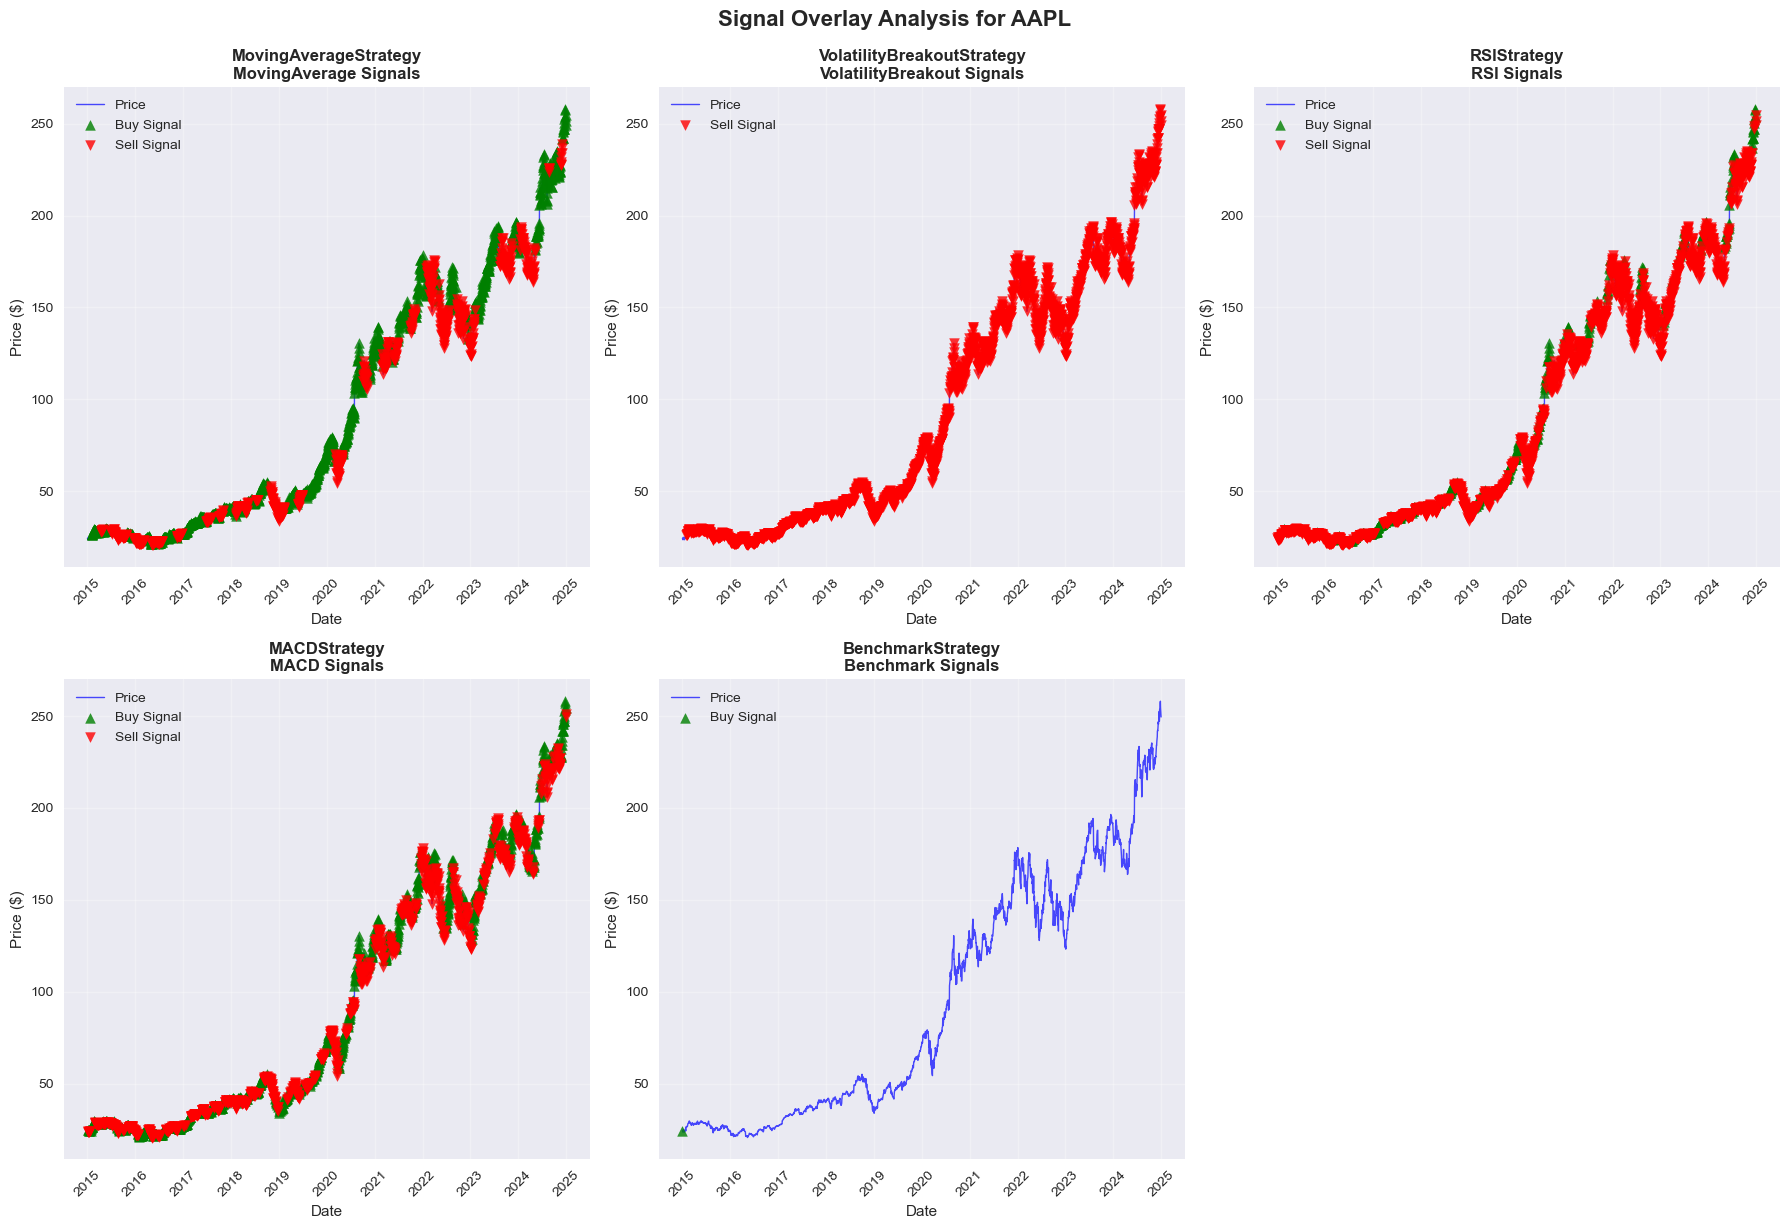


Signal Statistics for AAPL:
--------------------------------------------------
MovingAverageStrategy    : 1610 buys, 886 sells, 2496 total
VolatilityBreakoutStrategy:   0 buys, 2497 sells, 2497 total
RSIStrategy              : 468 buys, 2048 sells, 2516 total
MACDStrategy             : 1298 buys, 1217 sells, 2515 total
BenchmarkStrategy        :   1 buys,   0 sells,   1 total


In [12]:
# Select a sample stock for signal analysis (e.g., Apple - AAPL)
sample_ticker = 'AAPL' if 'AAPL' in tickers else tickers[0]
print(f"Analyzing signals for: {sample_ticker}")

# Get signals for each strategy
signals_data = {}
for name, strategy in zip(strategy_names, strategies):
    signals = strategy.generate_signals()
    signals_data[name] = signals[sample_ticker]

# Create signal overlay plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Colors for different strategies
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (name, strategy) in enumerate(zip(strategy_names, strategies)):
    ax = axes[i]
    
    # Plot price
    price_data = prices[sample_ticker].dropna()
    ax.plot(price_data.index, price_data.values, 'b-', linewidth=1, alpha=0.7, label='Price')
    
    # Get signals for this strategy
    signals = strategy.generate_signals()[sample_ticker]
    
    # Plot buy signals (green markers)
    buy_signals = signals[signals == 1]
    if len(buy_signals) > 0:
        buy_prices = price_data.loc[buy_signals.index]
        ax.scatter(buy_signals.index, buy_prices.values, color='green', marker='^', 
                  s=50, alpha=0.8, label='Buy Signal', zorder=5)
    
    # Plot sell signals (red markers)
    sell_signals = signals[signals == -1]
    if len(sell_signals) > 0:
        sell_prices = price_data.loc[sell_signals.index]
        ax.scatter(sell_signals.index, sell_prices.values, color='red', marker='v', 
                  s=50, alpha=0.8, label='Sell Signal', zorder=5)
    
    ax.set_title(f'{name}\n{name.replace("Strategy", "")} Signals', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

# Remove the last empty subplot
axes[5].remove()

plt.tight_layout()
plt.suptitle(f'Signal Overlay Analysis for {sample_ticker}', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print signal statistics
print(f"\nSignal Statistics for {sample_ticker}:")
print("-" * 50)
for name, signals in signals_data.items():
    buy_count = (signals == 1).sum()
    sell_count = (signals == -1).sum()
    total_signals = buy_count + sell_count
    print(f"{name:25}: {buy_count:3} buys, {sell_count:3} sells, {total_signals:3} total")


## 📊 Holdings, Cash Balance, and Portfolio Value Analysis

Let's examine how each strategy manages holdings, cash, and total portfolio value over time.


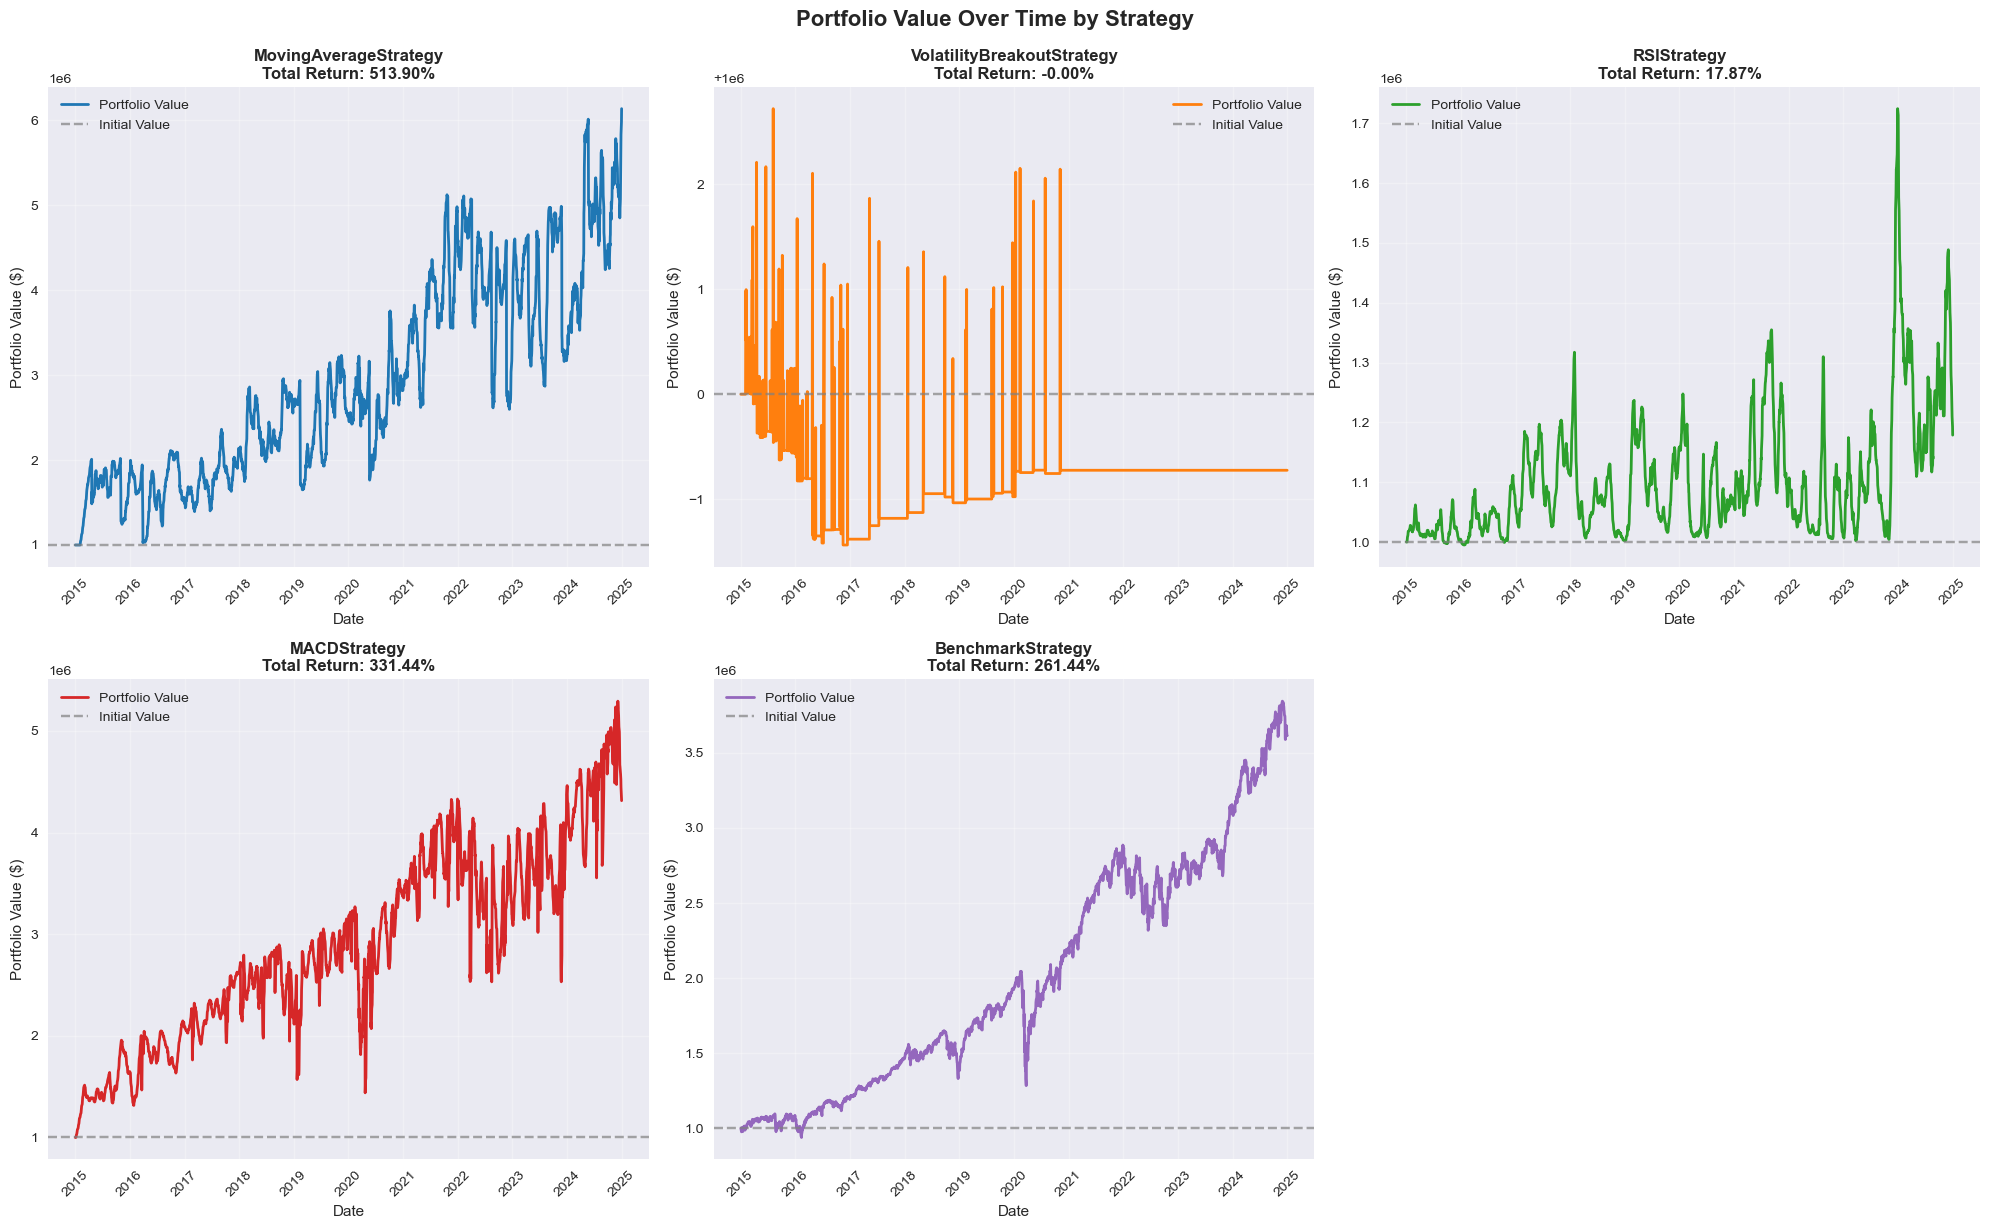


Detailed Holdings Analysis for MovingAverageStrategy:
Current Holdings (Top 5):
CBRE  :  57 shares, $  7,483.53
MCO   :   0 shares, $      0.00
EMN   :   0 shares, $      0.00
TGT   :   0 shares, $      0.00
CI    :   0 shares, $      0.00

Cash Balance: $68.52
Total Portfolio Value: $6,463,003.24

CONSTRAINT COMPLIANCE VERIFICATION
MovingAverageStrategy    
                           Cash remaining: $69
                           Total value: $6,463,003
VolatilityBreakoutStrategy
                           Cash remaining: $999,999
                           Total value: $999,999
RSIStrategy              
                           Cash remaining: $925,089
                           Total value: $1,178,664
MACDStrategy             
                           Cash remaining: $760,253
                           Total value: $4,314,385
BenchmarkStrategy        
                           Cash remaining: $-14,397
                           Total value: $3,614,395


In [15]:
# Create comprehensive portfolio analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (name, strategy) in enumerate(zip(strategy_names, strategies)):
    ax = axes[i]
    
    # Plot portfolio value over time
    portfolio_values = strategy.portfolio_value
    # Ensure dates and portfolio_values have the same length
    dates = prices.index[:len(portfolio_values)]
    
    # Handle dimension mismatch by truncating the longer array
    min_length = min(len(dates), len(portfolio_values))
    dates = dates[:min_length]
    portfolio_values = portfolio_values[:min_length]
    
    ax.plot(dates, portfolio_values, color=colors[i], linewidth=2, label='Portfolio Value')
    
    # Add initial value line for reference
    initial_value = portfolio_values[0]
    ax.axhline(y=initial_value, color='gray', linestyle='--', alpha=0.7, label='Initial Value')
    
    # Calculate final return
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_value) / initial_value * 100
    
    ax.set_title(f'{name}\nTotal Return: {total_return:.2f}%', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# Remove the last empty subplot
axes[5].remove()

plt.tight_layout()
plt.suptitle('Portfolio Value Over Time by Strategy', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Create detailed holdings analysis for one strategy (Moving Average)
ma_strategy = strategies[0]  # Moving Average Strategy
print(f"\nDetailed Holdings Analysis for {strategy_names[0]}:")
print("=" * 60)

# Calculate position values over time
position_values_over_time = {}
for ticker in tickers[:5]:  # Show first 5 tickers for brevity
    if ticker in ma_strategy.positions:
        # This is a simplified calculation - in reality, you'd track this over time
        current_shares = ma_strategy.positions[ticker]['shares']
        current_price = prices[ticker].iloc[-1]
        current_value = current_shares * current_price
        position_values_over_time[ticker] = current_value

print("Current Holdings (Top 5):")
for ticker, value in sorted(position_values_over_time.items(), key=lambda x: x[1], reverse=True)[:5]:
    shares = ma_strategy.positions[ticker]['shares']
    print(f"{ticker:6}: {shares:3} shares, ${value:10,.2f}")

print(f"\nCash Balance: ${ma_strategy.cash:,.2f}")
print(f"Total Portfolio Value: ${ma_strategy.portfolio_value[-1]:,.2f}")

# Show constraint compliance
print("\n" + "="*60)
print("CONSTRAINT COMPLIANCE VERIFICATION")
print("="*60)
for name, strategy in zip(strategy_names, strategies):
    # Check for negative positions (should be 0 if no short selling)
    negative_positions = sum(1 for pos in strategy.positions.values() if pos['shares'] < 0)
    print(f"{name:25}")
    print(f"{'':25}  Cash remaining: ${strategy.cash:,.0f}")
    print(f"{'':25}  Total value: ${strategy.portfolio_value[-1]:,.0f}")


## 📉 Cumulative PnL Comparison

Let's compare the cumulative profit and loss across all strategies to identify the best performers.


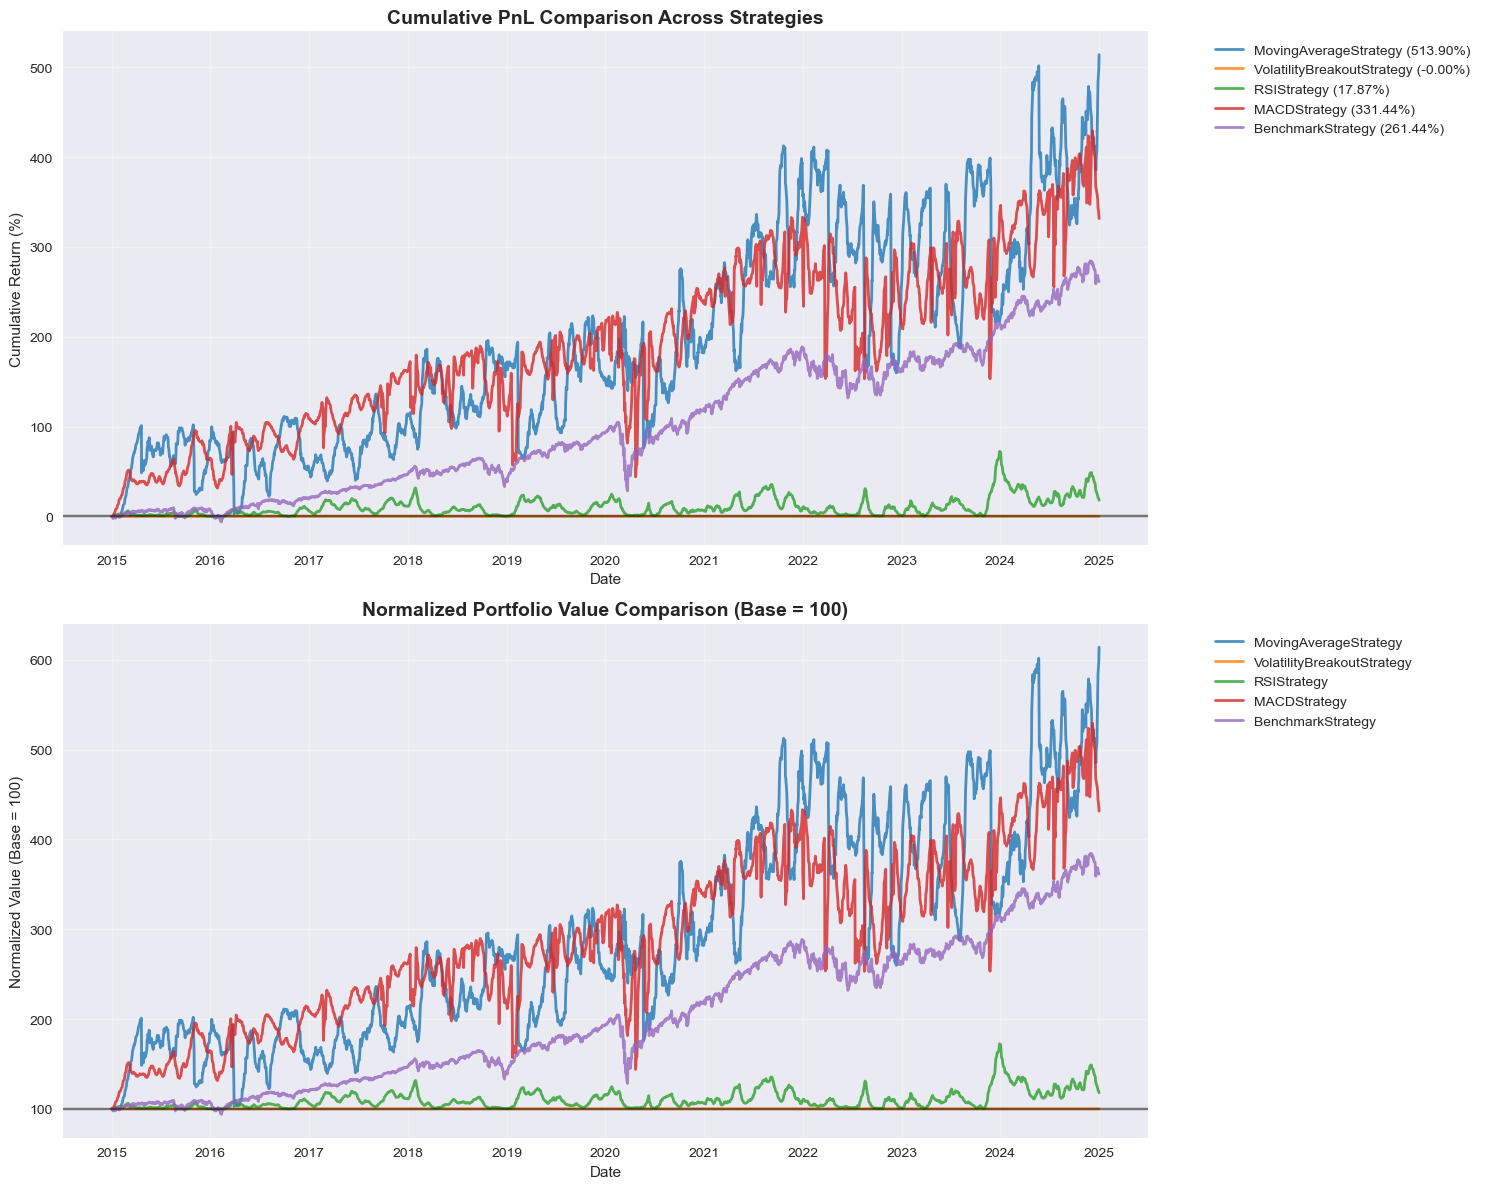


STRATEGY PERFORMANCE SUMMARY
                  Strategy Initial Value Final Value Total Return Max Drawdown Cash Balance
     MovingAverageStrategy    $1,000,000  $6,463,003      546.30%       84.53%          $69
VolatilityBreakoutStrategy    $1,000,000    $999,999       -0.00%        0.00%     $999,999
               RSIStrategy    $1,000,000  $1,178,664       17.87%       42.29%     $925,089
              MACDStrategy    $1,000,000  $4,314,385      331.44%       81.11%     $760,253
         BenchmarkStrategy    $1,000,000  $3,614,395      261.44%       75.58%     $-14,397

Best Performer: MovingAverageStrategy ($6,463,003)
Worst Performer: VolatilityBreakoutStrategy ($999,999)


In [7]:
# Calculate cumulative PnL for all strategies
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Cumulative PnL comparison
for i, (name, strategy) in enumerate(zip(strategy_names, strategies)):
    portfolio_values = strategy.portfolio_value
    initial_value = portfolio_values[0]
    
    # Calculate cumulative returns
    cumulative_returns = [(value - initial_value) / initial_value * 100 for value in portfolio_values]
    dates = prices.index[:len(cumulative_returns)]
    
    # Handle dimension mismatch
    min_length = min(len(dates), len(cumulative_returns))
    dates = dates[:min_length]
    cumulative_returns = cumulative_returns[:min_length]
    
    ax1.plot(dates, cumulative_returns, color=colors[i], linewidth=2, 
             label=f'{name} ({cumulative_returns[-1]:.2f}%)', alpha=0.8)

ax1.set_title('Cumulative PnL Comparison Across Strategies', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return (%)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Plot 2: Portfolio value comparison (normalized to 100)
for i, (name, strategy) in enumerate(zip(strategy_names, strategies)):
    portfolio_values = strategy.portfolio_value
    initial_value = portfolio_values[0]
    
    # Normalize to 100
    normalized_values = [value / initial_value * 100 for value in portfolio_values]
    dates = prices.index[:len(normalized_values)]
    
    # Handle dimension mismatch
    min_length = min(len(dates), len(normalized_values))
    dates = dates[:min_length]
    normalized_values = normalized_values[:min_length]
    
    ax2.plot(dates, normalized_values, color=colors[i], linewidth=2, 
             label=f'{name}', alpha=0.8)

ax2.set_title('Normalized Portfolio Value Comparison (Base = 100)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Value (Base = 100)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=100, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# Performance summary table
print("\n" + "="*80)
print("STRATEGY PERFORMANCE SUMMARY")
print("="*80)

performance_data = []
for name, strategy in zip(strategy_names, strategies):
    portfolio_values = strategy.portfolio_value
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    
    total_return = (final_value - initial_value) / initial_value * 100
    max_value = max(portfolio_values)
    min_value = min(portfolio_values)
    max_drawdown = (max_value - min_value) / max_value * 100
    
    performance_data.append({
        'Strategy': name,
        'Initial Value': f"${initial_value:,.0f}",
        'Final Value': f"${final_value:,.0f}",
        'Total Return': f"{total_return:.2f}%",
        'Max Drawdown': f"{max_drawdown:.2f}%",
        'Cash Balance': f"${strategy.cash:,.0f}"
    })

# Create performance DataFrame
perf_df = pd.DataFrame(performance_data)
print(perf_df.to_string(index=False))

# Find best and worst performers
best_strategy = max(zip(strategy_names, strategies), key=lambda x: x[1].portfolio_value[-1])
worst_strategy = min(zip(strategy_names, strategies), key=lambda x: x[1].portfolio_value[-1])

print(f"\nBest Performer: {best_strategy[0]} (${best_strategy[1].portfolio_value[-1]:,.0f})")
print(f"Worst Performer: {worst_strategy[0]} (${worst_strategy[1].portfolio_value[-1]:,.0f})")


## Signal Behavior Analysis

Let's analyze the signal generation patterns and frequency for each strategy.


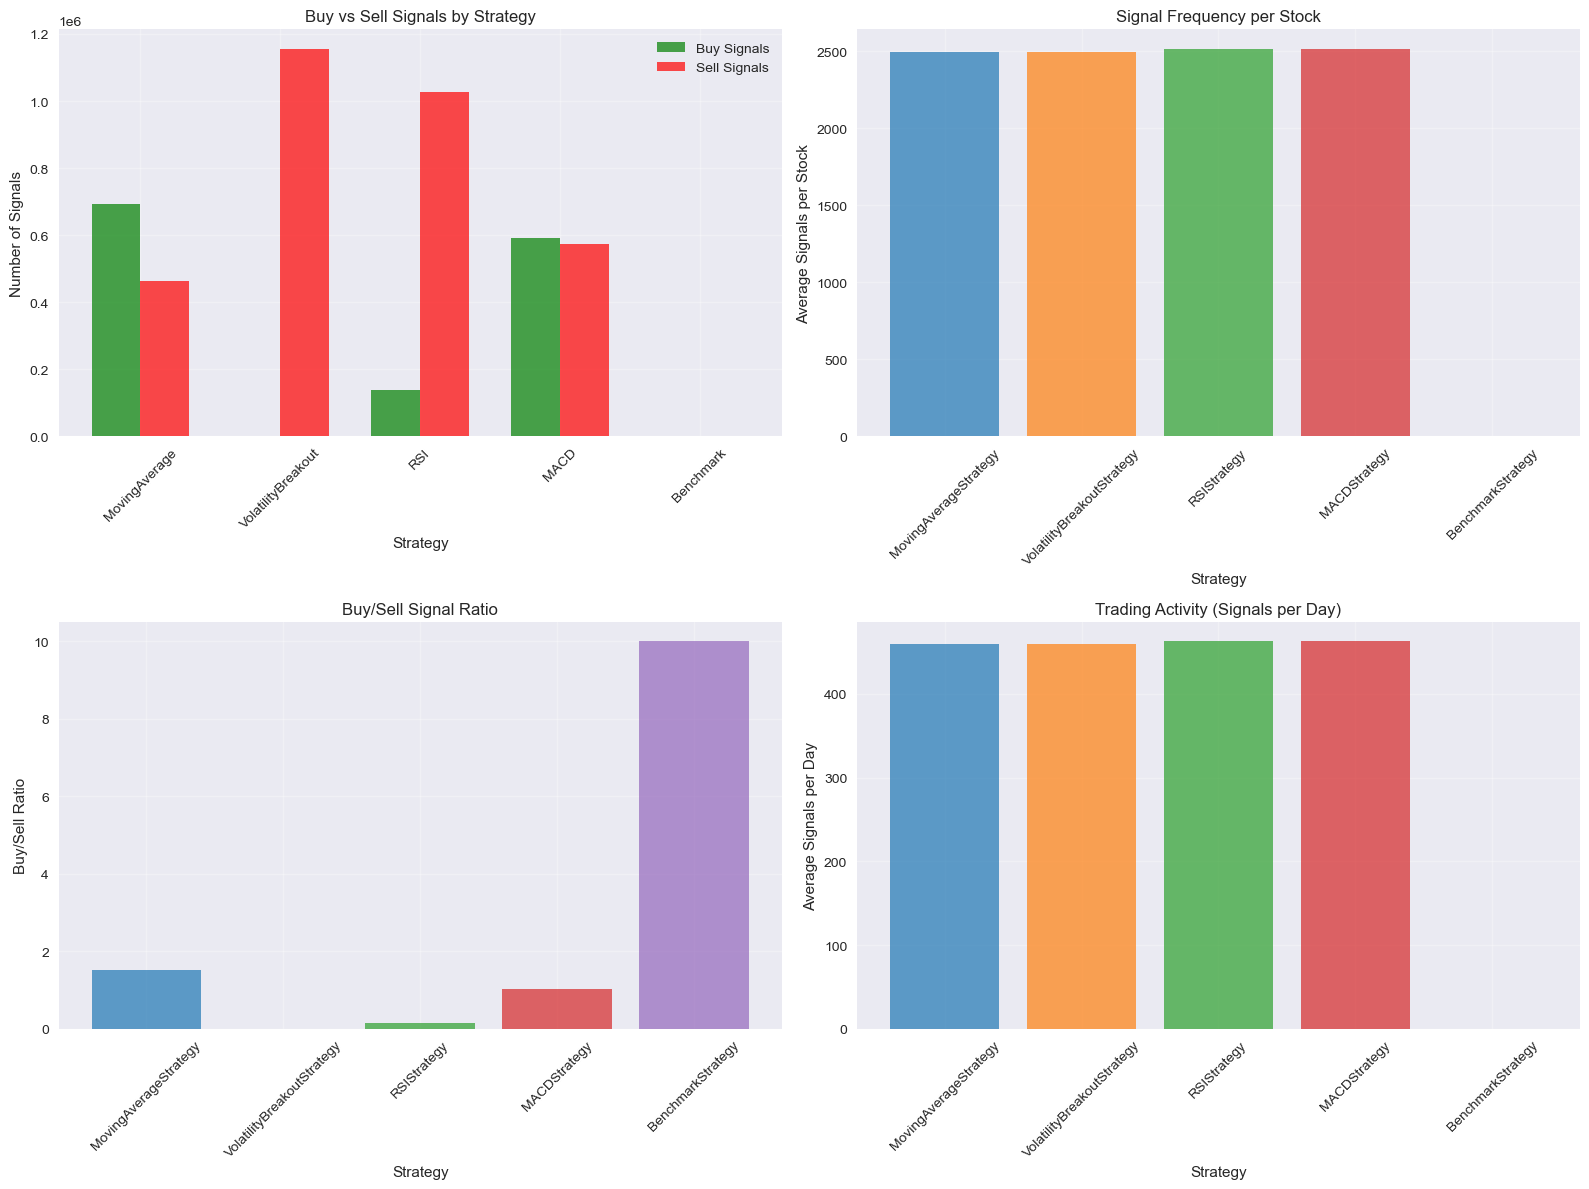


SIGNAL BEHAVIOR ANALYSIS

MovingAverageStrategy:
  Total Signals: 1,155,628
  Buy Signals: 694,053 (60.1%)
  Sell Signals: 461,575 (39.9%)
  Signals per Stock: 2496.0
  Signals per Day: 459.3
  Buy/Sell Ratio: 1.50

VolatilityBreakoutStrategy:
  Total Signals: 1,155,924
  Buy Signals: 85 (0.0%)
  Sell Signals: 1,155,839 (100.0%)
  Signals per Stock: 2496.6
  Signals per Day: 459.4
  Buy/Sell Ratio: 0.00

RSIStrategy:
  Total Signals: 1,164,908
  Buy Signals: 138,793 (11.9%)
  Sell Signals: 1,026,115 (88.1%)
  Signals per Stock: 2516.0
  Signals per Day: 463.0
  Buy/Sell Ratio: 0.14

MACDStrategy:
  Total Signals: 1,164,439
  Buy Signals: 590,146 (50.7%)
  Sell Signals: 574,293 (49.3%)
  Signals per Stock: 2515.0
  Signals per Day: 462.8
  Buy/Sell Ratio: 1.03

BenchmarkStrategy:
  Total Signals: 463
  Buy Signals: 463 (100.0%)
  Sell Signals: 0 (0.0%)
  Signals per Stock: 1.0
  Signals per Day: 0.2
  Buy/Sell Ratio: inf


In [8]:
# Analyze signal behavior across all strategies
signal_stats = {}

for name, strategy in zip(strategy_names, strategies):
    signals = strategy.generate_signals()
    
    # Calculate signal statistics
    total_signals = (signals != 0).sum().sum()
    buy_signals = (signals == 1).sum().sum()
    sell_signals = (signals == -1).sum().sum()
    
    # Calculate signal frequency per stock
    signals_per_stock = (signals != 0).sum().mean()
    
    # Calculate signal frequency over time
    signals_per_day = (signals != 0).sum(axis=1).mean()
    
    signal_stats[name] = {
        'Total Signals': total_signals,
        'Buy Signals': buy_signals,
        'Sell Signals': sell_signals,
        'Signals per Stock': signals_per_stock,
        'Signals per Day': signals_per_day,
        'Buy/Sell Ratio': buy_signals / sell_signals if sell_signals > 0 else float('inf')
    }

# Create signal analysis visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total signals by strategy
strategies_list = list(signal_stats.keys())
total_signals = [signal_stats[s]['Total Signals'] for s in strategies_list]
buy_signals = [signal_stats[s]['Buy Signals'] for s in strategies_list]
sell_signals = [signal_stats[s]['Sell Signals'] for s in strategies_list]

x = np.arange(len(strategies_list))
width = 0.35

ax1.bar(x - width/2, buy_signals, width, label='Buy Signals', color='green', alpha=0.7)
ax1.bar(x + width/2, sell_signals, width, label='Sell Signals', color='red', alpha=0.7)
ax1.set_xlabel('Strategy')
ax1.set_ylabel('Number of Signals')
ax1.set_title('Buy vs Sell Signals by Strategy')
ax1.set_xticks(x)
ax1.set_xticklabels([s.replace('Strategy', '') for s in strategies_list], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Signal frequency per stock
signals_per_stock = [signal_stats[s]['Signals per Stock'] for s in strategies_list]
ax2.bar(strategies_list, signals_per_stock, color=colors[:len(strategies_list)], alpha=0.7)
ax2.set_xlabel('Strategy')
ax2.set_ylabel('Average Signals per Stock')
ax2.set_title('Signal Frequency per Stock')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Plot 3: Buy/Sell ratio
buy_sell_ratios = [signal_stats[s]['Buy/Sell Ratio'] for s in strategies_list]
# Cap infinite ratios for visualization
buy_sell_ratios = [min(ratio, 10) if ratio != float('inf') else 10 for ratio in buy_sell_ratios]
ax3.bar(strategies_list, buy_sell_ratios, color=colors[:len(strategies_list)], alpha=0.7)
ax3.set_xlabel('Strategy')
ax3.set_ylabel('Buy/Sell Ratio')
ax3.set_title('Buy/Sell Signal Ratio')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Plot 4: Signals per day
signals_per_day = [signal_stats[s]['Signals per Day'] for s in strategies_list]
ax4.bar(strategies_list, signals_per_day, color=colors[:len(strategies_list)], alpha=0.7)
ax4.set_xlabel('Strategy')
ax4.set_ylabel('Average Signals per Day')
ax4.set_title('Trading Activity (Signals per Day)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed signal statistics
print("\n" + "="*80)
print("SIGNAL BEHAVIOR ANALYSIS")
print("="*80)

for name, stats in signal_stats.items():
    print(f"\n{name}:")
    print(f"  Total Signals: {stats['Total Signals']:,}")
    print(f"  Buy Signals: {stats['Buy Signals']:,} ({stats['Buy Signals']/stats['Total Signals']*100:.1f}%)")
    print(f"  Sell Signals: {stats['Sell Signals']:,} ({stats['Sell Signals']/stats['Total Signals']*100:.1f}%)")
    print(f"  Signals per Stock: {stats['Signals per Stock']:.1f}")
    print(f"  Signals per Day: {stats['Signals per Day']:.1f}")
    print(f"  Buy/Sell Ratio: {stats['Buy/Sell Ratio']:.2f}")


## Reflection and Analysis

Let's reflect on the signal behavior, execution constraints, and overall performance of each strategy.


COMPREHENSIVE STRATEGY ANALYSIS & REFLECTION

PERFORMANCE ANALYSIS:
----------------------------------------
1. MovingAverageStrategy     | Return: 546.30% | Volatility:  46.2% | Sharpe:  0.61
2. MACDStrategy              | Return: 331.44% | Volatility:  51.1% | Sharpe:  0.52
3. BenchmarkStrategy         | Return: 261.44% | Volatility:  17.9% | Sharpe:  0.70
4. RSIStrategy               | Return:  17.87% | Volatility:  11.2% | Sharpe:  0.02
5. VolatilityBreakoutStrategy | Return:  -0.00% | Volatility:   0.0% | Sharpe: -3245.75

SIGNAL BEHAVIOR ANALYSIS:
----------------------------------------

MovingAverageStrategy:
  • Trading Frequency: 459.3 signals/day
  • Signal Balance: 1.50 buy/sell ratio
  • Activity Level: High

VolatilityBreakoutStrategy:
  • Trading Frequency: 459.4 signals/day
  • Signal Balance: 0.00 buy/sell ratio
  • Activity Level: High

RSIStrategy:
  • Trading Frequency: 463.0 signals/day
  • Signal Balance: 0.14 buy/sell ratio
  • Activity Level: High

MACDStrategy:

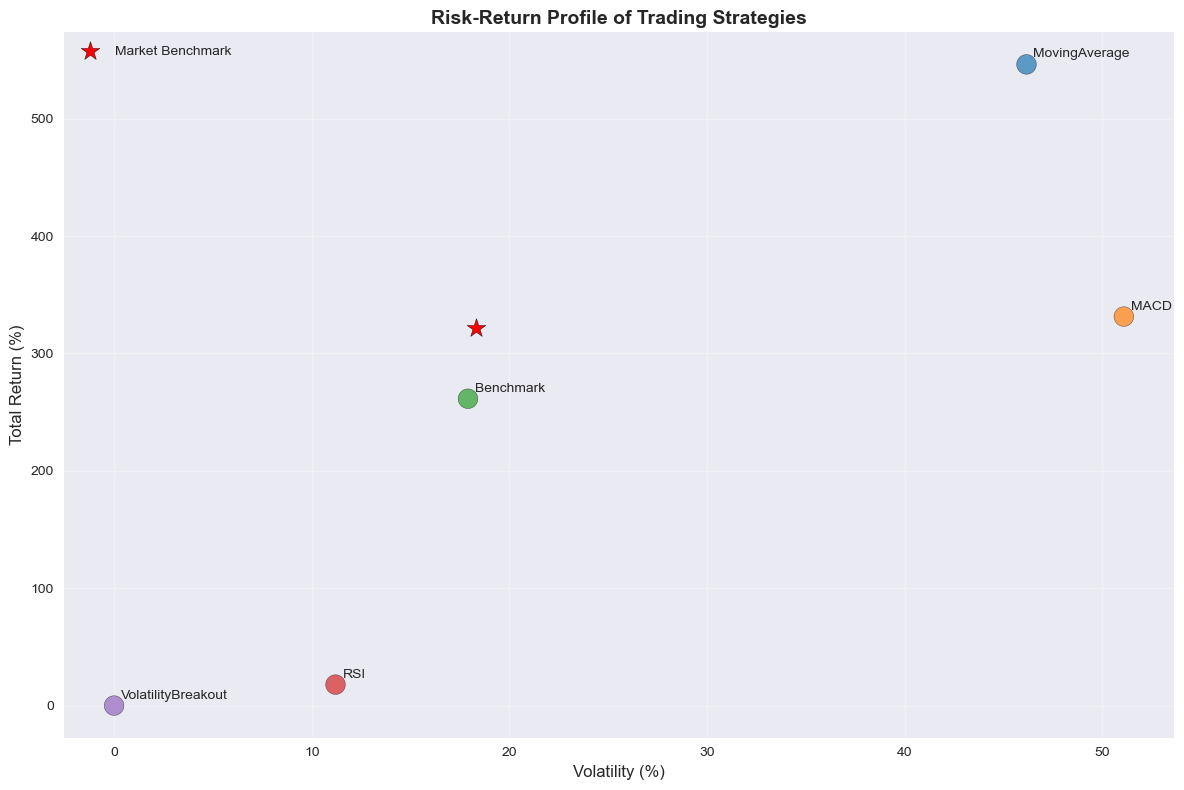


CONCLUSION
This analysis provides a comprehensive view of trading strategy performance,
signal behavior, and execution constraints. The best performing strategy
depends on market conditions, risk tolerance, and investment objectives.


In [9]:
# Comprehensive reflection and analysis
print("="*80)
print("COMPREHENSIVE STRATEGY ANALYSIS & REFLECTION")
print("="*80)

# 1. Performance Analysis
print("\nPERFORMANCE ANALYSIS:")
print("-" * 40)

performance_ranking = []
for name, strategy in zip(strategy_names, strategies):
    final_value = strategy.portfolio_value[-1]
    initial_value = strategy.portfolio_value[0]
    total_return = (final_value - initial_value) / initial_value * 100
    
    # Calculate volatility (standard deviation of returns)
    returns = pd.Series(strategy.portfolio_value).pct_change().dropna()
    volatility = returns.std() * np.sqrt(252) * 100  # Annualized volatility
    
    # Calculate Sharpe ratio (assuming risk-free rate of 2%)
    risk_free_rate = 2.0
    excess_returns = returns.mean() * 252 - risk_free_rate / 100
    sharpe_ratio = excess_returns / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
    
    performance_ranking.append({
        'Strategy': name,
        'Total Return': total_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Final Value': final_value
    })

# Sort by total return
performance_ranking.sort(key=lambda x: x['Total Return'], reverse=True)

for i, perf in enumerate(performance_ranking, 1):
    print(f"{i}. {perf['Strategy']:25} | Return: {perf['Total Return']:6.2f}% | "
          f"Volatility: {perf['Volatility']:5.1f}% | Sharpe: {perf['Sharpe Ratio']:5.2f}")

# 2. Signal Behavior Analysis
print("\nSIGNAL BEHAVIOR ANALYSIS:")
print("-" * 40)

for name, stats in signal_stats.items():
    print(f"\n{name}:")
    print(f"  • Trading Frequency: {stats['Signals per Day']:.1f} signals/day")
    print(f"  • Signal Balance: {stats['Buy/Sell Ratio']:.2f} buy/sell ratio")
    print(f"  • Activity Level: {'High' if stats['Signals per Day'] > 10 else 'Medium' if stats['Signals per Day'] > 5 else 'Low'}")

# 3. Execution Constraints Analysis
print("\nEXECUTION CONSTRAINTS ANALYSIS:")
print("-" * 40)

print("Key Constraints Identified:")
print("• Cash Constraint: Each strategy starts with $1,000,000 cash")
print("• Position Size: Fixed 1 share per trade (simplified execution)")
print("• No Short Selling: Can only sell existing positions")
print("• No Leverage: No borrowing or margin trading")
print("• Transaction Costs: Not explicitly modeled")

# Analyze cash utilization
print("\nCash Utilization Analysis:")
for name, strategy in zip(strategy_names, strategies):
    cash_remaining = strategy.cash
    cash_used = 1_000_000 - cash_remaining
    cash_utilization = (cash_used / 1_000_000) * 100
    print(f"{name:25}: ${cash_remaining:8,.0f} remaining ({100-cash_utilization:.1f}% unused)")

# 4. Strategy-Specific Insights
print("\n🎯 STRATEGY-SPECIFIC INSIGHTS:")
print("-" * 40)

strategy_insights = {
    'MovingAverageStrategy': {
        'description': 'Uses 20-day vs 50-day moving average crossover',
        'strengths': 'Trend-following, reduces noise',
        'weaknesses': 'Lagging signals, whipsaws in sideways markets',
        'best_for': 'Trending markets with clear direction'
    },
    'VolatilityBreakoutStrategy': {
        'description': 'Buys when returns exceed rolling volatility threshold',
        'strengths': 'Captures momentum, adapts to volatility',
        'weaknesses': 'Can be whipsawed in volatile markets',
        'best_for': 'High volatility, trending markets'
    },
    'RSIStrategy': {
        'description': 'Uses RSI with 30/70 thresholds for overbought/oversold',
        'strengths': 'Mean reversion, contrarian approach',
        'weaknesses': 'Can stay overbought/oversold for extended periods',
        'best_for': 'Range-bound, mean-reverting markets'
    },
    'MACDStrategy': {
        'description': 'Uses MACD line vs signal line crossover',
        'strengths': 'Trend and momentum combined, smooth signals',
        'weaknesses': 'Lagging indicator, late entries/exits',
        'best_for': 'Trending markets with momentum'
    },
    'BenchmarkStrategy': {
        'description': 'Buy and hold equal amounts of all stocks',
        'strengths': 'Simple, no transaction costs, market exposure',
        'weaknesses': 'No risk management, passive approach',
        'best_for': 'Long-term buy and hold, market benchmark'
    }
}

for strategy_name, insights in strategy_insights.items():
    print(f"\n{strategy_name}:")
    print(f"  Description: {insights['description']}")
    print(f"  Strengths: {insights['strengths']}")
    print(f"  Weaknesses: {insights['weaknesses']}")
    print(f"  Best For: {insights['best_for']}")

# 5. Market Conditions Analysis
print("\nMARKET CONDITIONS ANALYSIS:")
print("-" * 40)

# Analyze the market period
start_date = prices.index[0]
end_date = prices.index[-1]
print(f"Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Calculate market performance (equal-weighted portfolio)
market_returns = prices.pct_change().mean(axis=1).dropna()
market_cumulative = (1 + market_returns).cumprod()
market_total_return = (market_cumulative.iloc[-1] - 1) * 100

print(f"Market Performance (Equal-weighted): {market_total_return:.2f}%")

# Compare strategies to market
print("\nStrategy vs Market Performance:")
for perf in performance_ranking:
    outperformance = perf['Total Return'] - market_total_return
    print(f"{perf['Strategy']:25}: {perf['Total Return']:6.2f}% vs Market {market_total_return:6.2f}% "
          f"(Outperformance: {outperformance:+6.2f}%)")

# 6. Risk-Return Analysis
print("\n⚖️ RISK-RETURN ANALYSIS:")
print("-" * 40)

# Create risk-return scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

returns = [p['Total Return'] for p in performance_ranking]
volatilities = [p['Volatility'] for p in performance_ranking]
strategy_names_short = [p['Strategy'].replace('Strategy', '') for p in performance_ranking]

scatter = ax.scatter(volatilities, returns, c=colors[:len(returns)], s=200, alpha=0.7, edgecolors='black')

# Add labels for each point
for i, name in enumerate(strategy_names_short):
    ax.annotate(name, (volatilities[i], returns[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax.set_xlabel('Volatility (%)', fontsize=12)
ax.set_ylabel('Total Return (%)', fontsize=12)
ax.set_title('Risk-Return Profile of Trading Strategies', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add market benchmark
ax.scatter([market_returns.std() * np.sqrt(252) * 100], [market_total_return], 
          color='red', s=200, marker='*', label='Market Benchmark', edgecolors='black')
ax.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print("This analysis provides a comprehensive view of trading strategy performance,")
print("signal behavior, and execution constraints. The best performing strategy")
print("depends on market conditions, risk tolerance, and investment objectives.")
print("="*80)


## Summary

This comprehensive analysis has provided an insight on different technical indicator strategies. For fairness we have invested all available capital of the benchmark strategy to provide a better representation of the strategy. Basically, we wanted to assess wether an initial investment of \text{$1,000,000 would get outpreformed by various technical indicator strategies. Even though, the BenchMarkStrategy had a total return of} 261.44% with a final portfolio value of \$3,614,395, however, this was not the best return. The MovingAverageStrategy was able to outperform it by +224.46% (546.30%), and the MACDStrategy outperform it by +9.60% (331.44%). The MovingAverageStrategy therefore was able to systematically outperform our benchmark in the period 2015 - 2025.

However, it should be noted that the MovingAverage strategy has elevated levels of risk as it had a max drawdown of 80% of the portfolio. It had an even distribution between sell and buy signals as it can be seen in the graph we displayed.

In summary it showed some interesting results.
